In [ ]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import os
import re
import torch
import time
import requests
import random
import json
from dash import Dash, dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from geopy.geocoders import Nominatim
### WARNING : in env\Lib\site-packages\torch_geometric_temporal\nn\attention\tsagcn.py :
### change 'from torch_geometric.utils.to_dense_adj' by 'from torch_geometric.utils'
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import DCRNN, GConvGRU

In [3]:
def create_numbat_dataframe(data_dir, year, weekdays, sheet_name):
    df_numbat = pd.DataFrame()
    for weekday in weekdays.keys():
        df_day = pd.read_excel(os.path.join(data_dir, f'NUMBAT {year}', f'NBT{str(year)[-2:]}{weekday}_outputs.xlsx'), sheet_name=sheet_name,skiprows=2, header=0)
        df_day['weekday'] = weekday
        df_day['weekday_idx'] = df_day['weekday'].apply(lambda x : weekdays[x])
        df_day = df_day.sort_values(by='weekday_idx')
        df_day = df_day.reset_index(drop=True)
        df_day = df_day.reset_index()
        df_numbat = pd.concat((df_numbat, df_day))
    
    rename_dict = {
        'Early     ' : 'Early',
        'AM Peak   ' : 'AM Peak',
        'Midday    ' : 'Midday',
        'PM Peak   ' : 'PM Peak',
        'Evening   ' : 'Evening',
        'Late      ' : 'Late'
    }
    df_numbat = df_numbat.rename(columns=rename_dict)
    return df_numbat

In [4]:
weekdays = {'MON':0,
 'TWT':1,
 'FRI':2,
 'SAT':3,
 'SUN':4}

data_dir = 'data/'

In [5]:
df_numbat_station_entries = create_numbat_dataframe(data_dir, 2023, weekdays,'Station_Entries')
df_numbat_station_exits = create_numbat_dataframe(data_dir, 2023, weekdays, 'Station_Exits')
df_numbat_link_loads = create_numbat_dataframe(data_dir, 2023, weekdays, 'Link_Loads')

In [6]:
remove_suffixes = r'\s+(LU|LO|EL|NR|TfL|\(DIS\)|\(Bak\))$'
df_numbat_station_entries['Station_simplified'] = df_numbat_station_entries['Station'].apply(lambda x: re.sub(remove_suffixes, '', x))
df_numbat_station_exits['Station_simplified'] = df_numbat_station_exits['Station'].apply(lambda x: re.sub(remove_suffixes, '', x))

In [7]:
print(df_numbat_station_entries['Station_simplified'].nunique())
print(df_numbat_station_entries['Station'].nunique())

460
471


## Getting stations positions from TfL API

In [8]:
modes = ['tube', 'dlr', 'tram', 'national-rail', 'overground', 'elizabeth-line']
modes_str = ','.join(modes)

In [ ]:
unknown_loc_stations = []
max_retry = 5

for station in df_numbat_station_entries['Station_simplified'].unique():
    retries = 0
    while retries < max_retry:
        try:
            res = requests.get(f'https://api.tfl.gov.uk/StopPoint/Search?query={station}&modes={modes_str}')
            res.raise_for_status()
            res = res.json()
            
            if len(res['matches']) == 0:
                raise Exception('No match')
            print("Found location for station ", station)
            df_numbat_station_entries.loc[df_numbat_station_entries['Station_simplified'] == station, 'lat'] = res['matches'][0]['lat']
            df_numbat_station_entries.loc[df_numbat_station_entries['Station_simplified'] == station, 'lon'] = res['matches'][0]['lon']

            df_numbat_station_exits.loc[df_numbat_station_exits['Station_simplified'] == station, 'lat'] = res['matches'][0]['lat']
            df_numbat_station_exits.loc[df_numbat_station_exits['Station_simplified'] == station, 'lon'] = res['matches'][0]['lon']
            break

        except requests.exceptions.HTTPError as e:
            print('Request error : ', e)
            print('Sleeping for 60s...')
            time.sleep(60)
            retries += 1
            continue
        
        except Exception as e:
            print(f'Error for station {station} : {e}')
            unknown_loc_stations.append(station)
            break

        

In [ ]:
unknown_loc_stations

In [ ]:
df_numbat_station_exits['lat'].isna()

In [ ]:
lat, lon = 51.513395, -0.089095

df_numbat_station_entries.loc[df_numbat_station_entries['Station'] == 'Bank and Monument', 'lat'] = lat
df_numbat_station_entries.loc[df_numbat_station_entries['Station'] == 'Bank and Monument', 'lon'] = lon

df_numbat_station_exits.loc[df_numbat_station_exits['Station'] == 'Bank and Monument', 'lat'] = lat
df_numbat_station_exits.loc[df_numbat_station_exits['Station'] == 'Bank and Monument', 'lon'] = lon

lat, lon = 51.471618, -0.454037

df_numbat_station_entries.loc[df_numbat_station_entries['Station'] == 'Heathrow Terminals 123', 'lat'] = lat
df_numbat_station_entries.loc[df_numbat_station_entries['Station'] == 'Heathrow Terminals 123', 'lon'] = lon

df_numbat_station_exits.loc[df_numbat_station_exits['Station'] == 'Heathrow Terminals 123 LU', 'lat'] = lat
df_numbat_station_exits.loc[df_numbat_station_exits['Station'] == 'Heathrow Terminals 123 LU', 'lon'] = lon

## Getting stations locations from file

In [9]:
with open('station_data.json', 'r') as f:
    station_data = json.load(f)

station_to_locaction = {station['Station']: {'lat': station['lat'], 'lon': station['lon']} for station in station_data.values()}
station_to_locaction

{'Abbey Road': {'lat': 51.531926, 'lon': 0.003737},
 'Queensway': {'lat': 51.510312, 'lon': -0.187152},
 'Queensbury': {'lat': 51.594188, 'lon': -0.286219},
 'Queens Road Peckham': {'lat': 51.473566, 'lon': -0.057313},
 "Queen's Park": {'lat': 51.534443, 'lon': -0.204882},
 'Putney Bridge': {'lat': 51.468262, 'lon': -0.208731},
 'Pudding Mill Lane': {'lat': 51.534302, 'lon': -0.012755},
 'Prince Regent': {'lat': 51.509263, 'lon': 0.034158},
 'Preston Road': {'lat': 51.571972, 'lon': -0.295107},
 'Poplar': {'lat': 51.507744, 'lon': -0.017384},
 'Pontoon Dock': {'lat': 51.502212, 'lon': 0.032115},
 'Plaistow': {'lat': 51.531341, 'lon': 0.017451},
 'Pinner': {'lat': 51.592901, 'lon': -0.381161},
 'Pimlico': {'lat': 51.489097, 'lon': -0.133761},
 'Piccadilly Circus': {'lat': 51.51005, 'lon': -0.133798},
 'Phipps Bridge': {'lat': 51.403979, 'lon': -0.18164},
 'Perivale': {'lat': 51.536717, 'lon': -0.323446},
 'Penge West': {'lat': 51.417555, 'lon': -0.06084},
 'Peckham Rye': {'lat': 51.4700

In [10]:
df_numbat_station_entries['lat'] = df_numbat_station_entries['Station'].apply(lambda x : station_to_locaction[x]['lat'])
df_numbat_station_entries['lon'] = df_numbat_station_entries['Station'].apply(lambda x : station_to_locaction[x]['lon'])

df_numbat_station_exits['lat'] = df_numbat_station_exits['Station'].apply(lambda x : station_to_locaction[x]['lat'])
df_numbat_station_exits['lon'] = df_numbat_station_exits['Station'].apply(lambda x : station_to_locaction[x]['lon'])

## Feature extraction

In [11]:
num_links = df_numbat_link_loads['index'].nunique()
num_stations = df_numbat_station_exits['index'].nunique()

In [12]:
link_data = {
    i : df_numbat_link_loads.iloc[i][['From Station', 'To Station', 'Link', 'Line', 'Dir', 'Order']].to_dict()
    for i in range(num_links)
}

station_data = {
    i : df_numbat_station_exits.iloc[i][['Station', 'NLC', 'lat', 'lon']].to_dict()
    for i in range(num_stations)
}

In [13]:
lines_directions = {
    line : sorted(list(df_numbat_link_loads[df_numbat_link_loads['Line'] == line ]['Dir'].unique()))
    for line in df_numbat_link_loads['Line'].unique()
}
lines_directions

{'Bakerloo': ['NB', 'SB'],
 'LO West Anglia': ['NB', 'SB'],
 'London Trams': ['EB', 'WB'],
 'LO Watford-Euston': ['NB', 'SB'],
 'Metropolitan': ['NB', 'SB'],
 'LO Gospel Oak-Barking': ['EB', 'WB'],
 'LO East London': ['NB', 'SB'],
 'LO North London': ['EB', 'WB'],
 'LO Romford–Upminster': ['EB', 'WB'],
 'Piccadilly': ['EB', 'WB'],
 'Northern': ['NB', 'SB'],
 'Victoria': ['NB', 'SB'],
 'District': ['EB', 'WB'],
 'DLR': ['IB', 'OB'],
 'Central': ['EB', 'WB'],
 'Waterloo & City': ['EB', 'WB'],
 'H&C and Circle': ['IR', 'OR'],
 'Jubilee': ['NB', 'SB'],
 'Elizabeth Line': ['EB', 'WB']}

In [14]:
nlc_idx = {
    nlc : i for i, nlc in df_numbat_station_entries[df_numbat_station_entries['weekday_idx'] == 0][['index','NLC']].values
}

df_numbat_station_entries['NLC_idx'] = df_numbat_station_entries['NLC'].apply(lambda x : nlc_idx[x])
df_numbat_station_exits['NLC_idx'] = df_numbat_station_exits['NLC'].apply(lambda x : nlc_idx[x])

df_numbat_link_loads['From NLC_idx'] = df_numbat_link_loads['From NLC'].apply(lambda x : nlc_idx[x])
df_numbat_link_loads['To NLC_idx'] = df_numbat_link_loads['To NLC'].apply(lambda x : nlc_idx[x])

In [15]:
df_quarter = pd.read_excel(os.path.join(data_dir, 'NBT22_Definitions_Published.xlsm'), header=0, sheet_name='Qhr')
df_quarter['Time'] = df_quarter['Time'].replace('2345-2400', '2345-0000')
time_to_quarter = {
    time : {'qhr' : i, 'hour' : hour, 'tb' : tb} for i, (time, tb, hour) in enumerate(df_quarter[['Time', 'Timeband', 'Hour']].values)
}

In [16]:
### TODO: fix this !!!!!!
ordered_qhr = {qhr : qhr_idx for qhr_idx, qhr in enumerate(df_numbat_station_entries.columns[12:-6])}

In [17]:
df_snap_station_entries = df_numbat_station_entries.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_entries = df_snap_station_entries.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_entries = df_snap_station_entries.reset_index()


df_snap_station_exits = df_numbat_station_exits.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_exits = df_snap_station_exits.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_exits = df_snap_station_exits.reset_index()


df_snap_link_loads = df_numbat_link_loads.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index', 'Dir', 'Line', 'Order', 'Link', 'From Station', 'To Station', 'weekday'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)


In [18]:
num_qhr = len(ordered_qhr)
df_snap_link_loads['new_index'] = (df_snap_link_loads['weekday_idx'])*num_qhr+ df_snap_link_loads['quarter_hour_idx']
# df_snap_link_loads = df_snap_link_loads.sort_values(by='new_index')
# df_snap_link_loads = df_snap_link_loads.reset_index(drop=True)

In [20]:
# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_link_loads = df_snap_link_loads.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_link_loads = df_snap_link_loads.reset_index()

In [21]:
station_entries = []
station_entries_features = []

station_exits = []
station_exits_features = []

link_loads = []
link_loads_features = []
lag = 4 
for i in range(len(df_snap_station_entries)):
# for i in range(len(df_snap_station_entries)-lag):
    
    lag_index = np.roll(df_snap_link_loads.index.to_list(), -i)[:lag][::-1]

    station_entries.append(df_snap_station_entries.iloc[i].to_numpy()[2:])
    station_exits.append(df_snap_station_exits.iloc[i].to_numpy()[2:])
    link_loads.append(df_snap_link_loads.iloc[i].to_numpy()[2:])

    entries_lag_features = df_snap_station_entries.iloc[lag_index].to_numpy().T[2:]
    exits_lag_features = df_snap_station_exits.iloc[lag_index].to_numpy().T[2:]
    loads_lag_features = df_snap_link_loads.iloc[lag_index].to_numpy().T[2:]

    entries_features = np.concatenate(
        (entries_lag_features, np.tile(df_snap_station_entries.iloc[i].to_numpy()[:2], (len(entries_lag_features), 1))), axis=1)
    exits_features = np.concatenate(
        (exits_lag_features, np.tile(df_snap_station_exits.iloc[i].to_numpy()[:2], (len(exits_lag_features), 1))), axis=1)
    loads_features = np.concatenate(
        (loads_lag_features, np.tile(df_snap_link_loads.iloc[i].to_numpy()[:2], (len(loads_lag_features), 1))), axis=1)

    station_entries_features.append(entries_features)
    station_exits_features.append(exits_features)
    link_loads_features.append(loads_features)


In [22]:
edge_idx = [[], []]
for s,e in df_numbat_link_loads[df_numbat_link_loads['weekday'] == 'MON'][["From NLC", "To NLC"]].values:
    edge_idx[0].append(nlc_idx[s])
    edge_idx[1].append(nlc_idx[e])

edge_idx = np.array(edge_idx, dtype=int)
# edge_idx = torch.tensor(edge_idx, dtype=int)

In [23]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, num_date_features, num_lag_features):
        super(RecurrentGCN, self).__init__()

        self.num_date_features = num_date_features
        self.num_lag_features = num_lag_features
        self.hidden_dim = 32
        self.recurrent1 = DCRNN(self.num_date_features, self.hidden_dim, 1)
        self.station_entry_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_lag_features + self.hidden_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.station_exit_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_lag_features + self.hidden_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.link_load_head = torch.nn.Sequential(
            torch.nn.Linear(2 * self.hidden_dim + self.num_lag_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),)

    def forward(self, x_entries, x_exits, x_loads, edge_index, edge_weight):
        
        h_date_station = self.recurrent1(x_entries[:,-self.num_date_features:], edge_index, edge_weight)
        h_date_station = F.relu(h_date_station)

        h_entries = torch.cat([x_entries[:, :-self.num_date_features], h_date_station], dim=1)
        h_exits = torch.cat([x_exits[:, :-self.num_date_features], h_date_station], dim=1)

        h_date_link = torch.cat([h_date_station[edge_index[0]], h_date_station[edge_index[1]]], dim=1)
        h_loads = torch.cat([x_loads[:, :-self.num_date_features], h_date_link], dim=1)

        station_entries = self.station_entry_head(h_entries)
        station_exits = self.station_exit_head(h_exits)
        link_loads = self.link_load_head(h_loads)
        
        return station_entries, station_exits, link_loads

## Data split + training

In [24]:
numbat_2023_ent_ex_dataset = StaticGraphTemporalSignal(
    edge_index=edge_idx,
    edge_weight=None,
    features=station_entries_features,
    targets=station_entries,
    features_exits=station_exits_features,
    targets_exits=station_exits,
    features_loads=link_loads_features,
    targets_loads=link_loads,
)

print(numbat_2023_ent_ex_dataset.snapshot_count)

numbat_train_dataset, numbat_test_dataset = temporal_signal_split(numbat_2023_ent_ex_dataset, train_ratio=0.8)
numbat_train_dataset, numbat_dev_dataset = temporal_signal_split(numbat_train_dataset, train_ratio=0.9)

480


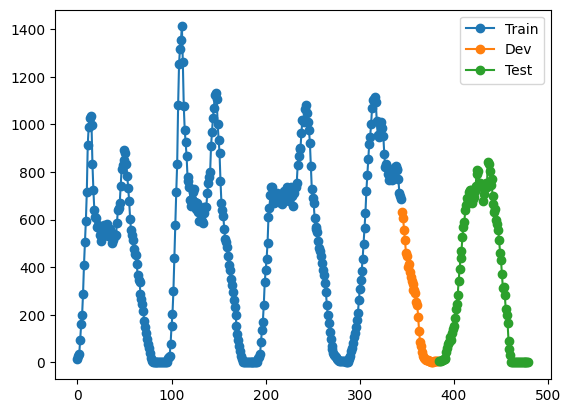

In [25]:
idx = random.randint(0, numbat_train_dataset[0].x.shape[0] -1)

train_val = [snapshot.y[idx] for snapshot in numbat_train_dataset]
dev_val = [snapshot.y[idx] for snapshot in numbat_dev_dataset]
test_val = [snapshot.y[idx] for snapshot in numbat_test_dataset]

num_snap_train = numbat_train_dataset.snapshot_count
num_snap_dev = numbat_dev_dataset.snapshot_count
num_snap_test = numbat_test_dataset.snapshot_count

plt.plot(range(num_snap_train),train_val, label='Train', marker='o')
plt.plot(range(num_snap_train, num_snap_train+ num_snap_dev),dev_val, label='Dev', marker='o')
plt.plot(range(num_snap_train+ num_snap_dev, num_snap_train+ num_snap_dev+num_snap_test),test_val, label='Test', marker='o')
plt.legend()
plt.show()

Epoch 0


  0%|          | 0/345 [00:00<?, ?it/s]c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\env\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([471])) that is different to the input size (torch.Size([471, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\env\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1206])) that is different to the input size (torch.Size([1206, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 345/345 [00:05<00:00, 67.67it/s]


Train Loss - Entries 60728.15234375; Exits: 64030.82421875; Loads 326702.53125


100%|██████████| 39/39 [00:00<00:00, 89.28it/s]


Dev Loss - Entries 24711.865234375; Exits: 17557.001953125; Loads: 102883.3125


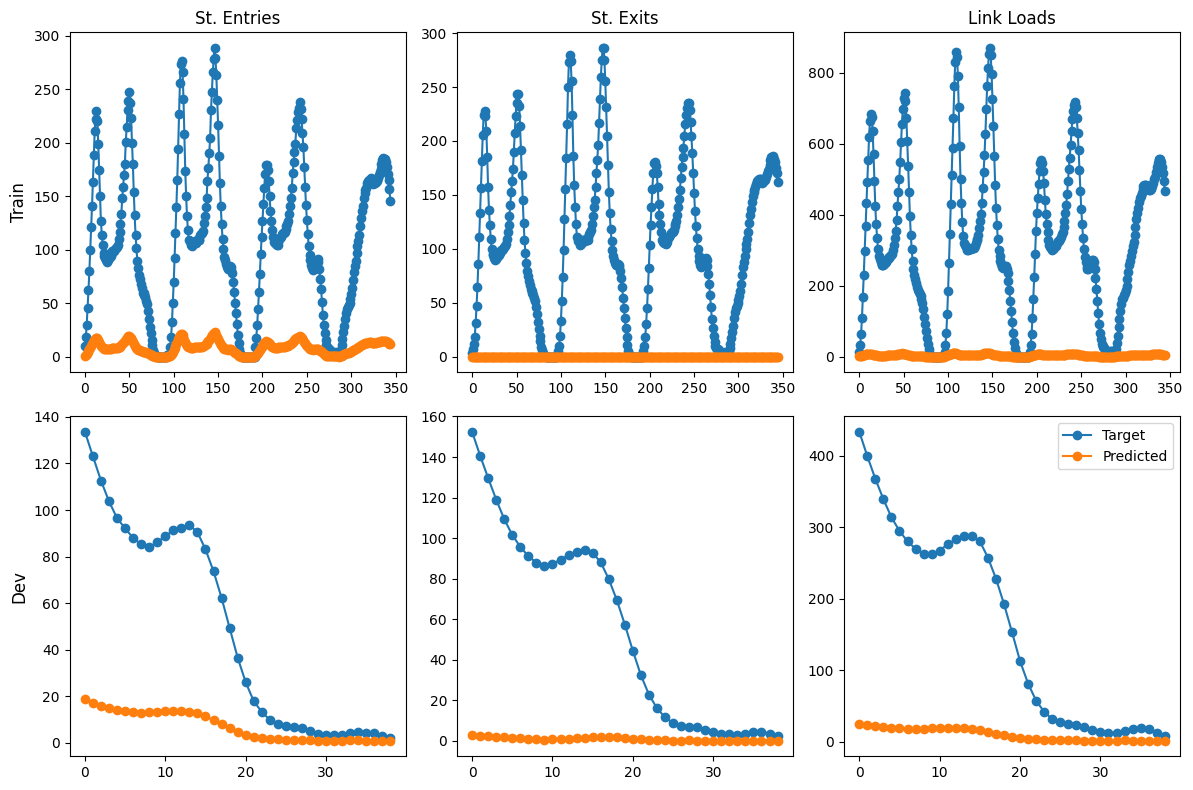

Epoch 1


100%|██████████| 345/345 [00:03<00:00, 96.45it/s] 


Epoch 2


100%|██████████| 345/345 [00:03<00:00, 104.62it/s]


Epoch 3


100%|██████████| 345/345 [00:03<00:00, 109.32it/s]


Epoch 4


100%|██████████| 345/345 [00:03<00:00, 105.23it/s]


Epoch 5


100%|██████████| 345/345 [00:03<00:00, 107.38it/s]


Epoch 6


100%|██████████| 345/345 [00:03<00:00, 95.84it/s] 


Epoch 7


100%|██████████| 345/345 [00:03<00:00, 94.74it/s] 


Epoch 8


100%|██████████| 345/345 [00:03<00:00, 96.41it/s] 


Epoch 9


100%|██████████| 345/345 [00:03<00:00, 108.96it/s]


Epoch 10


100%|██████████| 345/345 [00:03<00:00, 109.18it/s]


Train Loss - Entries 58404.5625; Exits: 59759.17578125; Loads 266572.625


100%|██████████| 39/39 [00:00<00:00, 90.88it/s]


Dev Loss - Entries 24612.90234375; Exits: 15984.5; Loads: 88927.9453125


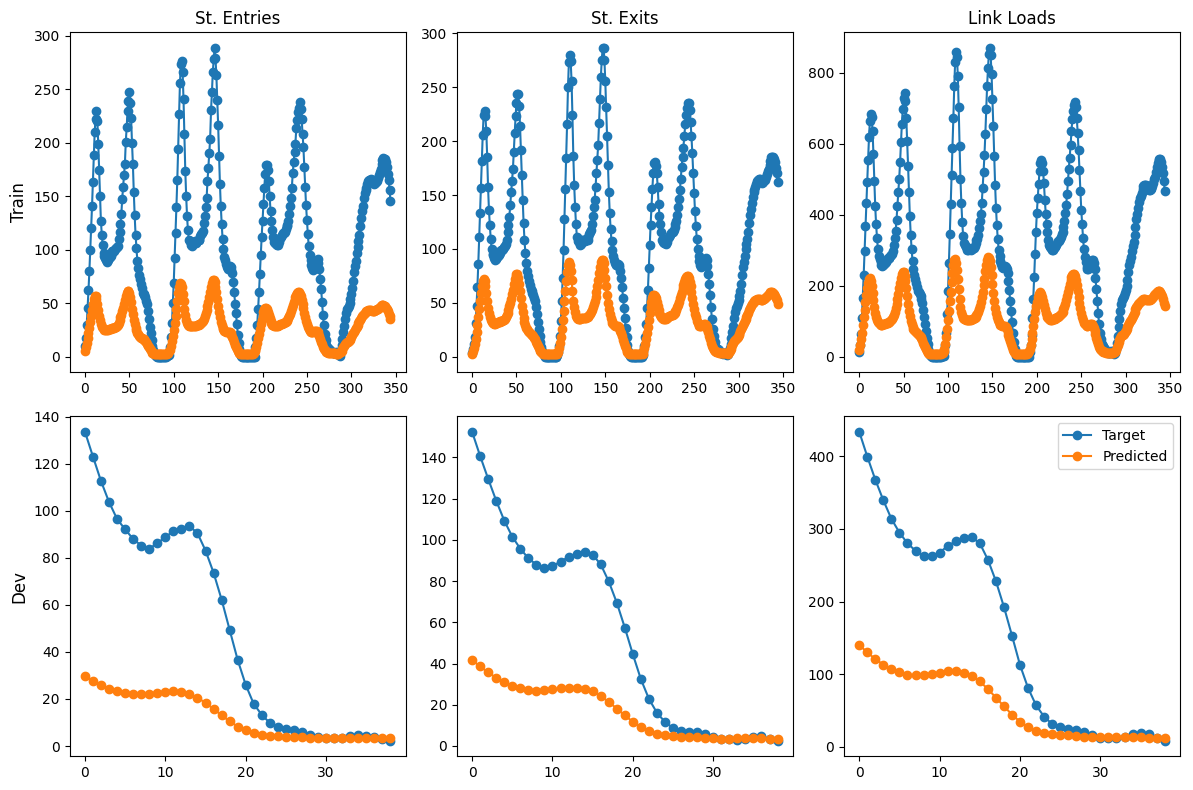

Epoch 11


100%|██████████| 345/345 [00:03<00:00, 97.78it/s] 


KeyboardInterrupt: 

In [26]:
model = RecurrentGCN(num_lag_features=lag, num_date_features=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion =torch.nn.
criterion =torch.nn.MSELoss()
# criterion =torch.nn.L1Loss()
epochs = 20
num_stations = numbat_dev_dataset[0].x.shape[0]
num_links = numbat_dev_dataset[0].edge_index.shape[1]

for epoch in range(epochs):
    ### TRAIN

    model.train()
    print("Epoch", epoch)

    entries_train_loss = 0
    exits_train_loss = 0
    loads_train_loss = 0

    entries_pred_plot = np.empty((num_snap_train, num_stations))
    entries_true_plot = np.empty((num_snap_train, num_stations))

    exits_pred_plot = np.empty((num_snap_train, num_stations))
    exits_true_plot = np.empty((num_snap_train, num_stations))

    loads_pred_plot = np.empty((num_snap_train, num_links))
    loads_true_plot = np.empty((num_snap_train, num_links))

    for time, snapshot in tqdm(enumerate(numbat_train_dataset), total=num_snap_train):
        pred_entries, pred_exits, pred_loads = model(
            snapshot.x, 
            snapshot.features_exits, 
            snapshot.features_loads, 
            snapshot.edge_index, snapshot.edge_attr)
        entries_train_loss = entries_train_loss + criterion(pred_entries, snapshot.y)
        exits_train_loss = exits_train_loss + criterion(pred_exits, snapshot.targets_exits)
        loads_train_loss = loads_train_loss + criterion(pred_loads, snapshot.targets_loads)

        entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
        entries_true_plot[time] = snapshot.y.numpy()

        exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
        exits_true_plot[time] = snapshot.targets_exits.numpy()

        loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
        loads_true_plot[time] = snapshot.targets_loads.numpy()
    
    entries_train_loss = entries_train_loss / num_snap_train
    exits_train_loss = exits_train_loss / num_snap_train
    loads_train_loss = loads_train_loss / num_snap_train
    
    train_loss = entries_train_loss + exits_train_loss + loads_train_loss
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch%10 == 0:
        # print("Train Loss:", train_loss.item())
        print("Train Loss - Entries {}; Exits: {}; Loads {}".format(
            entries_train_loss.item(), exits_train_loss.item(), loads_train_loss.item()
        ))
        
        fig, axs = plt.subplots(2, 3, sharex='row', figsize=(12, 8))

        for ax, col in zip(axs[0], ('St. Entries', 'St. Exits', 'Link Loads')):
            ax.set_title(col)

        for ax, row in zip(axs[:,0], ('Train', 'Dev')):
            ax.set_ylabel(row, size='large')
        axs[0,0].plot(range(num_snap_train),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        axs[0,0].plot(np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')

        axs[0,1].plot(np.mean(exits_true_plot, axis=1), label='Target', marker='o')
        axs[0,1].plot(np.mean(exits_pred_plot, axis=1), label='Predicted', marker='o')

        axs[0,2].plot(np.mean(loads_true_plot, axis=1), label='Target', marker='o')
        axs[0,2].plot(np.mean(loads_pred_plot, axis=1), label='Predicted', marker='o')

    ### EVAL
        model.eval()
        entries_dev_loss = 0
        exits_dev_loss = 0
        loads_dev_loss = 0

        entries_pred_plot = np.empty((num_snap_dev, num_stations))
        entries_true_plot = np.empty((num_snap_dev, num_stations))

        exits_pred_plot = np.empty((num_snap_dev, num_stations))
        exits_true_plot = np.empty((num_snap_dev, num_stations))

        loads_pred_plot = np.empty((num_snap_dev, num_links))
        loads_true_plot = np.empty((num_snap_dev, num_links))
        for time, snapshot in tqdm(enumerate(numbat_dev_dataset), total=num_snap_dev):
            pred_entries, pred_exits, pred_loads = model(
                snapshot.x, 
                snapshot.features_exits, 
                snapshot.features_loads, 
                snapshot.edge_index, snapshot.edge_attr)
            
            entries_dev_loss = entries_dev_loss + criterion(pred_entries, snapshot.y)
            exits_dev_loss = exits_dev_loss + criterion(pred_exits, snapshot.targets_exits)
            loads_dev_loss = loads_dev_loss + criterion(pred_loads, snapshot.targets_loads)

            entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
            entries_true_plot[time] = snapshot.y.numpy()

            exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
            exits_true_plot[time] = snapshot.targets_exits.numpy()

            loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
            loads_true_plot[time] = snapshot.targets_loads.numpy()

        entries_dev_loss = entries_dev_loss / num_snap_dev
        exits_dev_loss = exits_dev_loss / num_snap_dev
        loads_dev_loss = loads_dev_loss / num_snap_dev

        print("Dev Loss - Entries {}; Exits: {}; Loads: {}".format(
            entries_dev_loss.item(), exits_dev_loss.item(), loads_dev_loss.item()
        ))
        axs[1,0].plot(range(num_snap_dev),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        axs[1,0].plot(np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')

        axs[1,1].plot(np.mean(exits_true_plot, axis=1), label='Target', marker='o')
        axs[1,1].plot(np.mean(exits_pred_plot, axis=1), label='Predicted', marker='o')

        axs[1,2].plot(np.mean(loads_true_plot, axis=1), label='Target', marker='o')
        axs[1,2].plot(np.mean(loads_pred_plot, axis=1), label='Predicted', marker='o')

        fig.tight_layout()
        plt.legend()
        plt.show()

In [27]:
model.eval()
cost = 0
num_snapshot = numbat_test_dataset.snapshot_count
for time, snapshot in tqdm(enumerate(numbat_test_dataset), total=num_snapshot):
    y_hat, _, _ = model(snapshot.x, snapshot.features_exits, snapshot.features_loads, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / num_snapshot
cost = cost.item()
print("MSE Entries: {:.4f}".format(cost))

100%|██████████| 96/96 [00:00<00:00, 108.81it/s]

MSE Entries: 24425.4551


In [28]:
ts_predicted_loads = []
ts_predicted_entries = []
ts_predicted_exits = []

ts_true_loads = []
ts_true_entries = []
ts_true_exits = []

for _, snapshot in tqdm(enumerate(numbat_2023_ent_ex_dataset)):
    pred_entries, pred_exits, pred_loads = model(
        snapshot.x, 
        snapshot.features_exits, 
        snapshot.features_loads, 
        snapshot.edge_index, snapshot.edge_attr)
    
    for i in range(len(pred_entries)):
        ts_predicted_entries.append(pred_entries[i].detach().numpy()[0])
        ts_true_entries.append(float(snapshot.y[i].numpy()))

        ts_predicted_exits.append(pred_exits[i].detach().numpy()[0])
        ts_true_exits.append(float(snapshot.targets_exits[i].numpy()))

    for i, pred in enumerate(pred_loads):
        ts_predicted_loads.append(pred.detach().numpy()[0])
        ts_true_loads.append(float(snapshot.targets_loads[i].numpy()))


df_pred_link_loads = pd.DataFrame({'pred_flow' : ts_predicted_loads, 'actual_flow' : ts_true_loads})
df_pred_link_loads['From Station'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['From Station'])
df_pred_link_loads['To Station'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['To Station'])
df_pred_link_loads['Line'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['Line'])
df_pred_link_loads['Dir'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['Dir'])
df_pred_link_loads['Order'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['Order'])
df_pred_link_loads['Link'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['Link'])
df_pred_link_loads['time_idx'] = df_pred_link_loads.index.map(lambda x : x//num_links)

df_pred_station = pd.DataFrame({
    'pred_entries' : ts_predicted_entries,
    'actual_entries' : ts_true_entries,
    'pred_exits' : ts_predicted_exits,
    'actual_exits' : ts_true_exits
    })

df_pred_station['Station'] = df_pred_station.index.map(lambda x : station_data[x%num_stations]['Station'])
df_pred_station['NLC'] = df_pred_station.index.map(lambda x : station_data[x%num_stations]['NLC'])
df_pred_station['lat'] = df_pred_station.index.map(lambda x : station_data[x%num_stations]['lat'])
df_pred_station['lon'] = df_pred_station.index.map(lambda x : station_data[x%num_stations]['lon'])
df_pred_station['time_idx'] = df_pred_station.index.map(lambda x : x//num_stations)

480it [00:31, 15.19it/s]


## Dash visualization

In [31]:
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

#### Layout

##### Network Map

In [32]:
df_plot = df_pred_station.sort_values(by='time_idx')
fig = px.scatter_map(df_pred_station,
                    lat="lat",
                    lon="lon",
                    size="pred_entries",
                    animation_frame="time_idx",
                    size_max=15,
                    zoom=10,
                    width=1000,
                    height=1000
                    )

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
network_map_tab = dbc.Tab(label="Network Map", children=[
    dbc.Spinner(dcc.Graph(figure=fig)),
    
])

##### Stations

In [33]:
df_plot = df_pred_station.groupby('time_idx')[['pred_entries', 'actual_entries', 'pred_exits', 'actual_exits']].mean().reset_index()
df_plot = df_plot.melt(
        id_vars=['time_idx'],
        value_vars=['pred_entries', 'actual_entries', 'pred_exits', 'actual_exits',],
        var_name='Type',
)

df_plot['Flow Type'] = df_plot['Type'].apply(lambda x: 'Entries' if 'entries' in x else 'Exits')
df_plot['Prediction Type'] = df_plot['Type'].apply(lambda x: 'Predicted' if 'pred' in x else 'Actual')

fig = px.line(
    df_plot,
    x='time_idx',
    y='value',
    facet_col="Flow Type",
    color='Prediction Type',
    title="Averaged Station Flows over Time"
)

station_tab = dbc.Tab(label="Stations", children=[
    dbc.Spinner(dcc.Graph(figure=fig)),
    html.P("Select a station:"),
    dcc.Dropdown(
        id='select-station',
        options=list(df_pred_station['Station'].unique()),
        searchable=True,
    ),
    dbc.Button(
        'Run',
        id='load-graph-station',
        class_name='btn-primary'

    ),
    dbc.Spinner(
        dcc.Graph(
            id="graph-station-flow",
        )
    ),
    
])

@app.callback(
    Output("graph-station-flow", "figure"), 
    Input('load-graph-station', 'n_clicks'),
    State("select-station", "value"),
    prevent_initial_call=True
    )

def display_station_graph(n_clicks, station):
    df_plot = df_pred_station[(df_pred_station['Station'] == station)].reset_index(drop=True)
    df_plot = df_plot.melt(
        id_vars=['time_idx', 'Station', 'NLC'],
        value_vars=['pred_entries', 'actual_entries', 'pred_exits', 'actual_exits'],
        var_name='Type',
    ).sort_values(by=['time_idx'])
    
    df_plot['Flow Type'] = df_plot['Type'].apply(lambda x: 'Entries' if 'entries' in x else 'Exits')
    df_plot['Prediction Type'] = df_plot['Type'].apply(lambda x: 'Predicted' if 'pred' in x else 'Actual')

    fig = px.line(
        df_plot,
        x='time_idx',
        y='value',
        facet_col="Flow Type",
        color='Prediction Type',
        title=f"Station Flows over Time for {station}"
    )
    
    
    return fig

##### Links

In [34]:
df_plot = df_pred_link_loads.groupby('time_idx')[['actual_flow', 'pred_flow']].mean().reset_index()
df_plot = df_plot.melt(
        id_vars=['time_idx'],
        value_vars=['actual_flow', 'pred_flow'],
        var_name='Type',
)

fig = px.line(
    df_plot,
    x='time_idx',
    y='value',
    color='Type',
    title="Averaged Link Load over Time"
)

links_tab = dbc.Tab(label="Links", children=[
    dbc.Spinner(dcc.Graph(figure=fig)),
    html.P("Select a link:"),
    dcc.Dropdown(
        id='select-link',
        options=[{'label' : f"{link_data[i]['From Station']} - {link_data[i]['To Station']}", 'value' : link_data[i]['Link']} for i in range(num_links)],
        searchable=True,
    ),
    dbc.Button(
        'Run',
        id='load-graph-link',
        class_name='btn-primary'

    ),
    dbc.Spinner(
        dcc.Graph(
            id="graph-link-flow",
        )
    ),
    
])

@app.callback(
    Output("graph-link-flow", "figure"), 
    Input('load-graph-link', 'n_clicks'),
    State("select-link", "value"),
    prevent_initial_call=True
    )

def display_link_graph(n_clicks, link):
    df_plot = df_pred_link_loads[(df_pred_link_loads['Link'] == link)].reset_index(drop=True)
    df_plot = df_plot.melt(
        id_vars=['Order', 'Link', 'From Station', 'To Station', 'time_idx'],
        value_vars=['actual_flow', 'pred_flow'],
        var_name='Type',

    ).sort_values(by=['time_idx'])
    
    fig = px.line(
        df_plot,
        x='time_idx',
        y='value',
        color='Type',
        title=f"Station Flow for {link}"
    )
    
    
    return fig

##### Lines

In [35]:
lines_tab = dbc.Tab(label="Lines", children=[
    html.P("Select a line:"),
    dcc.Dropdown(
        id='select-line',
        options=list(df_pred_link_loads['Line'].unique()),
    ),
    html.P("Select a direction:"),
    dbc.RadioItems(
        id='select-dir',
        options=[],
        inline=True,
    ),
    dbc.Button(
        'Run',
        id='load-graph',
        class_name='btn-primary'

    ),
    dbc.Spinner(
        dcc.Graph(
            id="graph-line-flow",
        )
    ),
])

@app.callback(
    Output("select-dir", "options"),
    Input("select-line", "value"),
    prevent_initial_call=True,
)
def update_line_directions(line):
    return lines_directions[line]

@app.callback(
    Output("graph-line-flow", "figure"), 
    Input('load-graph', 'n_clicks'),
    State("select-line", "value"),
    State("select-dir", "value"),
    prevent_initial_call=True
    )
def display_lines_graph(n_clicks, line, dir):
    df_plot = df_pred_link_loads[(df_pred_link_loads['Line'] == line) & (df_pred_link_loads['Dir'] == dir)].reset_index(drop=True)

    df_plot = df_plot.melt(
        id_vars=['Order', 'Link', 'From Station', 'To Station', 'time_idx'],
        value_vars=['actual_flow', 'pred_flow'],
        var_name='Type',

    ).sort_values(by=['Order', 'time_idx'])
    fig = px.line(df_plot, 
        x='Order',
        y='value',
        color='Type',
        # y='pred_flow',
        # error_y='flow',
        # y='flow',
        animation_frame='time_idx',
        hover_name='Link',
        hover_data=['From Station', 'To Station'],
        range_y=[min(df_plot['value'].min(),df_plot['value'].min()), max(df_plot['value'].max(),df_plot['value'].max())]
        )
    
    
    return fig

#### Run App

In [36]:
app.layout = dbc.Container([
    html.H1('Flow Forecasting'),
    dbc.Tabs([
        network_map_tab,
        station_tab,
        links_tab,
        lines_tab,
    ]),
])

app.run_server(debug=True, jupyter_mode="tab")

Dash app running on http://127.0.0.1:8050/


<IPython.core.display.Javascript object>